In [1]:
import os
from einops import repeat
import matplotlib.pyplot as plt
from tqdm import tqdm

# torch
import torch
import torch.nn as nn

# custom imports
from ddpm import Diffusion
from model import Classifier
from dataset.helpers import *
from util import set_seed, prepare_dataloaders

def show_n_forward(imgs, title=None, fig_titles=None, save_path=None): 
    if fig_titles is not None:
        assert len(imgs) == len(fig_titles)

    num_rows = len(imgs) // 7
    fig_width = 20  # Adjust the figure width as needed
    fig_height = 2 * num_rows  # Adjust the figure height as needed
    fig, axs = plt.subplots(num_rows, ncols=7, figsize=(fig_width, fig_height))

    for i in range(num_rows):
        for j in range(7):
            idx = i * 7 + j
            axs[i, j].imshow(imgs[idx])
            axs[i, j].axis('off')
            if fig_titles is not None:
                axs[i, j].set_title(fig_titles[idx])

    if title is not None:
        plt.suptitle(title)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)

    plt.show()



Diffusion type: DDPM


Eval: 100%|██████████| 10000/10000 [01:51<00:00, 89.36it/s]


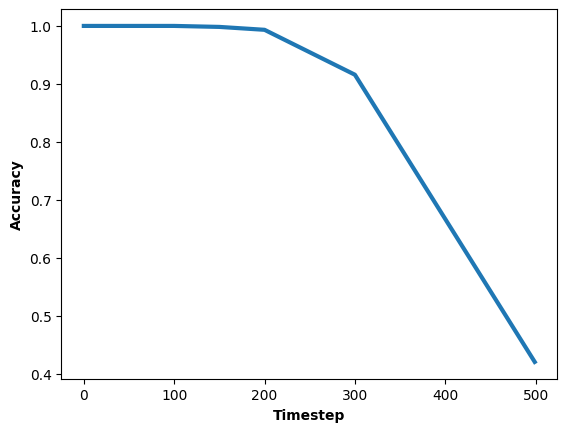

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed()
os.makedirs('assets', exist_ok=True)

# Initialize diffusion class
diffusion = Diffusion(img_size=16, T=500, beta_start=1e-4, beta_end=0.02, device=device)

# Load classifier
model = Classifier(
    img_size=16, c_in=3, labels=5,
    time_dim=256, channels=32, device=device
)
model.to(device)
model.eval()
model.load_state_dict(torch.load('weights/classifier/model.pth', map_location=device))

# sample time steps
t = torch.Tensor([0, 50, 100, 150, 200, 300, 499]).long().to(device)

# softmax
softmax = nn.Softmax(dim=-1)

########################################## Per Timestep Accuracy ##########################################
_, val_loader, _ = prepare_dataloaders(100, val_batch_size=1)
per_t_acc = torch.zeros_like(t, dtype=torch.float32)
for img, label in tqdm(val_loader, desc='Eval'):
    img = img.to(device)
    label = label.to(device)
    label = repeat(label, '1 -> (b 1)', b=t.shape[0])
    x_t, noise = diffusion.q_sample(img, t)

    with torch.no_grad():
        logits = model(x_t, t)

    out = softmax(logits)
    prediction = torch.argmax(out, dim=-1)
    
    assert prediction.shape == label.shape
    per_t_acc += prediction == label
    
per_t_acc /= len(val_loader)

plt.figure()
plt.plot(t.cpu().numpy(), per_t_acc.cpu().numpy(), linewidth=3)
plt.xlabel('Timestep', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.savefig('./assets/per_t_accuracy.png', bbox_inches='tight')




In [5]:
print(t)
print(per_t_acc)

tensor([  0,  50, 100, 150, 200, 300, 499], device='cuda:0')
tensor([1.0000, 1.0000, 1.0000, 0.9983, 0.9933, 0.9159, 0.4210],
       device='cuda:0')


tensor([[6.9304e-06, 1.1361e-04, 2.5649e-05, 9.9985e-01, 5.0140e-06],
        [6.0733e-06, 1.1719e-04, 2.2413e-05, 9.9985e-01, 4.5518e-06],
        [6.0001e-06, 1.2323e-04, 2.4512e-05, 9.9984e-01, 4.5599e-06],
        [4.9046e-06, 2.3472e-04, 4.2857e-05, 9.9971e-01, 4.6224e-06],
        [7.2599e-06, 2.5613e-04, 5.9802e-05, 9.9967e-01, 6.8225e-06],
        [5.0514e-04, 1.9277e-02, 4.7210e-03, 9.7501e-01, 4.8307e-04],
        [5.6149e-02, 2.3339e-01, 4.3073e-02, 4.9121e-01, 1.7617e-01]],
       device='cuda:0')
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
tensor([[6.1879e-06, 7.9053e-05, 1.7472e-05, 9.9989e-01, 5.6996e-06],
        [6.5713e-06, 7.0484e-05, 1.6611e-05, 9.9990e-01, 6.2517e-06],
        [6.3213e-06, 7.5563e-05, 1.7063e-05, 9.9990e-01, 5.8928e-06],
        [5.0121e-06, 8.5270e-05, 2.2915e-05, 9.9988e-01, 5.3352e-06],
        [5.3604e-06, 1.0630e-04, 2.9576e-05, 9.9985e-01, 6.1843e-06],
        [5.6554e-05, 2.0403e-03, 4.9816e-04, 9

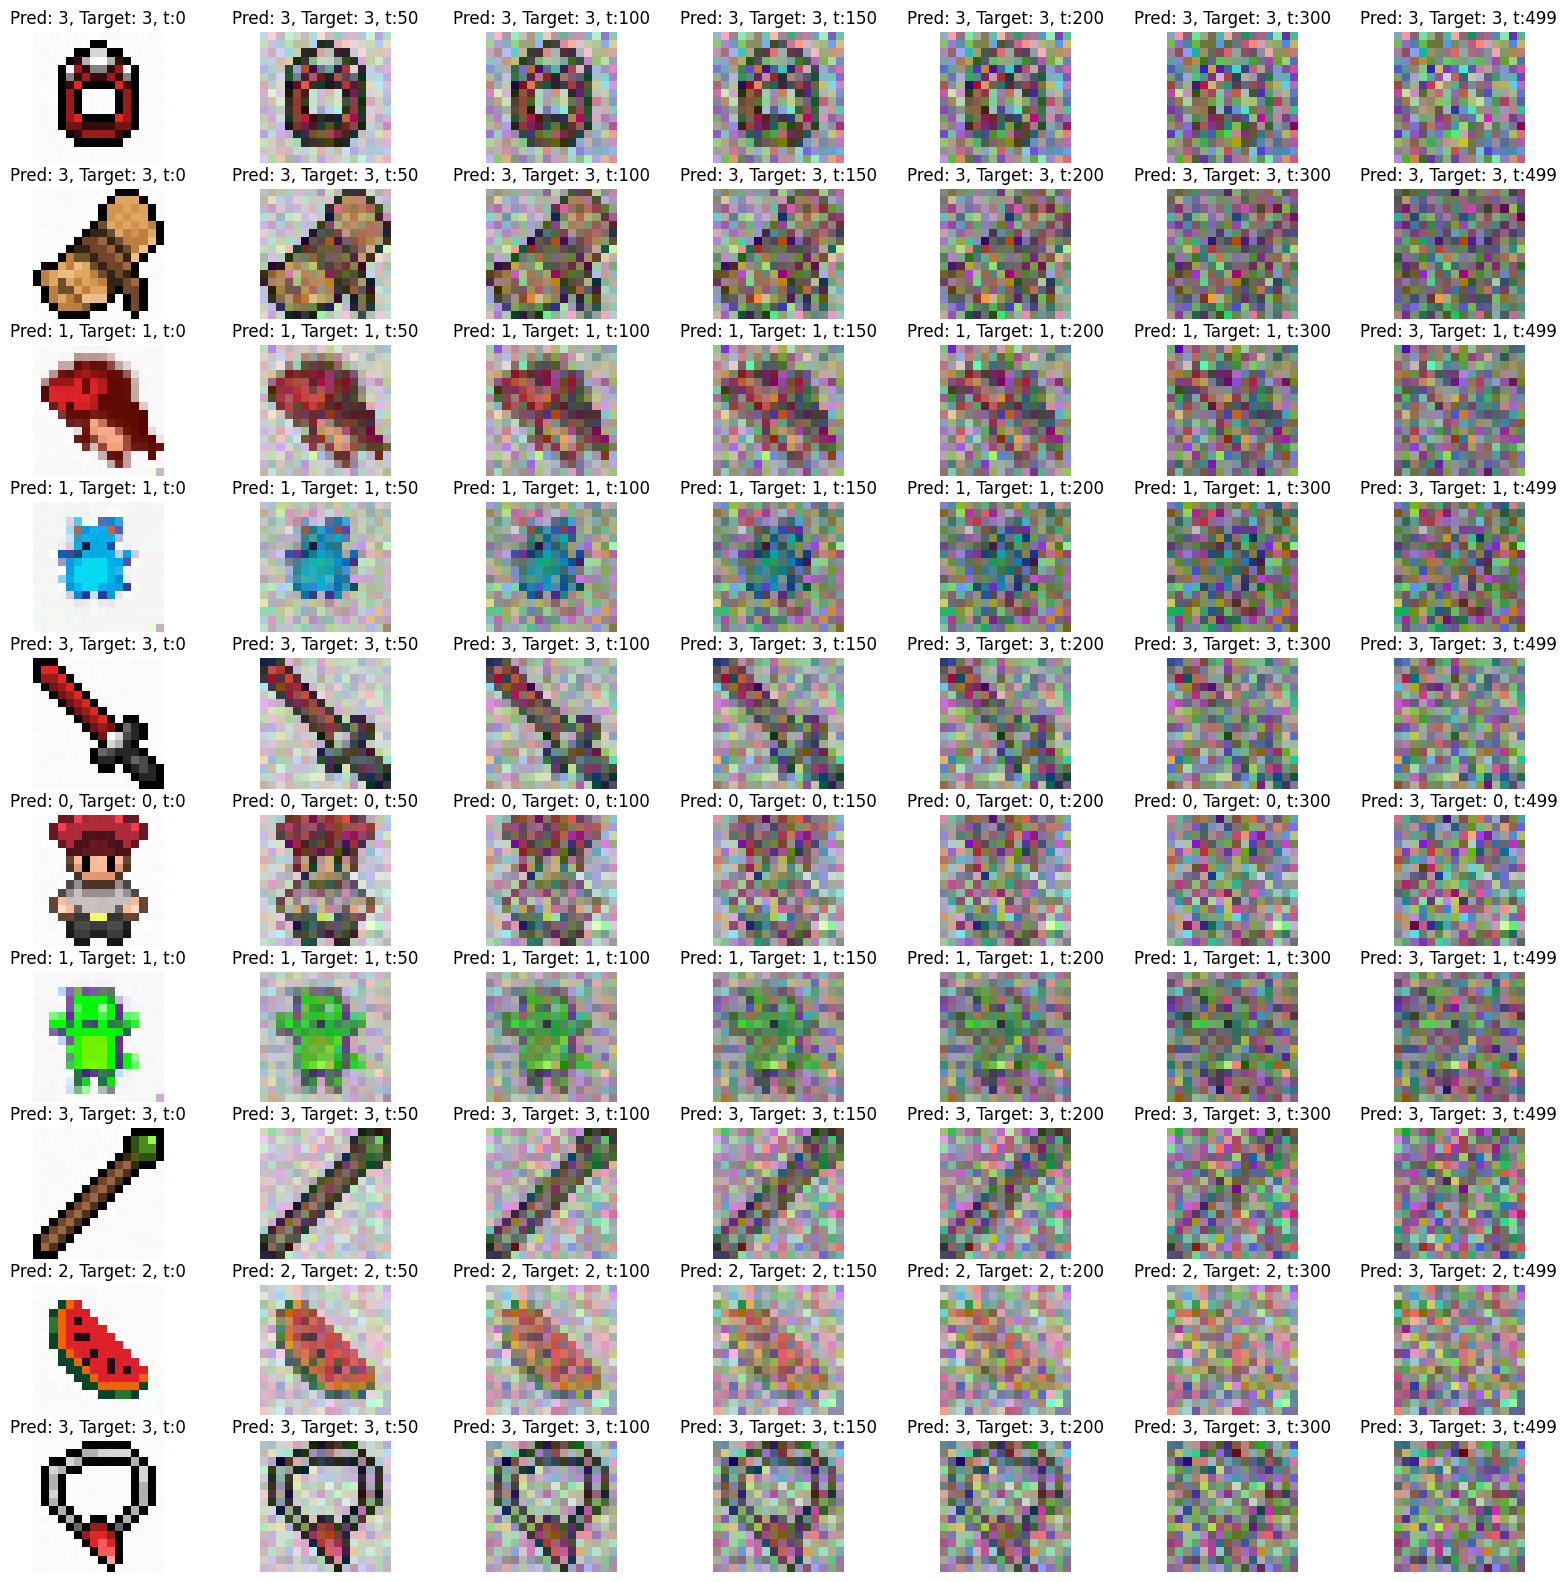

In [3]:
########################################## Qualitative Results ############################################
_, val_loader,_ = prepare_dataloaders(100, val_batch_size=10)
images, labels = next(iter(val_loader))
images = images.to(device)
labels = labels.to(device)

vis_images = []
vis_labels = []
for img, label in zip(images, labels):
    img = img.unsqueeze(0)
    label = label.unsqueeze(0)
    label = repeat(label, '1 -> (b 1)', b=t.shape[0])
    x_t, noise = diffusion.q_sample(img, t)

    with torch.no_grad():
        logits = model(x_t, t)
    
    out = softmax(logits)
    print(out)
    print(torch.sum(out,dim=-1))
    prediction = torch.argmax(out, dim=-1)

    norm_images = [im_normalize(tens2image(im.cpu().detach())) for im in x_t]
    vis_images.extend(norm_images)
    text_labels = [f'Pred: {pred.item()}, Target: {l.item()}, t:{ti.item()}' for pred, l,ti in zip(prediction, label, t)]
    vis_labels.extend(text_labels)

show_n_forward(vis_images, fig_titles=vis_labels, save_path='assets/clf_forward.png')


In [6]:
train_loader, _, _ = prepare_dataloaders()

Check majority class in training

In [10]:
labs = []
for _, lab in train_loader:
    labs.append(lab.tolist())


[0 1 2 3 4]
[ 3636 14280  2698 15727  3659]


<BarContainer object of 5 artists>

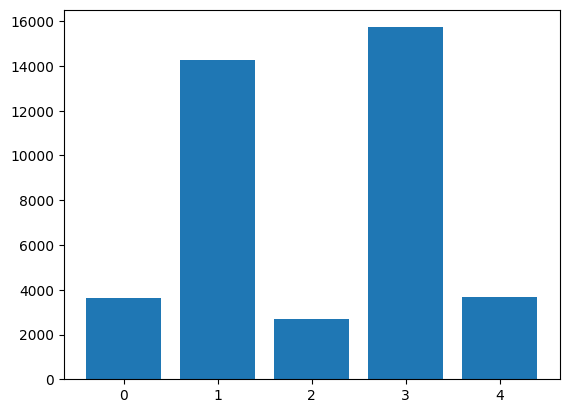

In [13]:
import numpy as np 

classLab,count = np.unique(labs,return_counts=True)
print(classLab)
print(count)
plt.bar(classLab,height=count)